# Ramsey Model: Shooting Method
_07.02.2024_

__Daniel Fisch__

The following code solves the terminal value problem of the Ramsey model numerically by the shooting method. The parameters of the model and the production function as well as its derivative and the resulting steady state solution of the Ramsey model have to be specified. Then the algorithm will iteratively solve the terminal value problem for an initial consumption $c_0$ until an error threshold $\epsilon_0$ is reached.

In [1]:
# using Pkg
# Pkg.add("Plots")

using Plots

## Parameters

In [2]:
# Parameter for Ramsey model
σ = 0.5 # effective curvature
ρ = 0.05 # discount factor (e^-ρt)
δ = 0.05 # depreciation
n = 0.02 # population growth parameter

# Production function f
A = 1 # technology
α = 1/3 # power in production function
f(k) = A .* k.^α # production function
df(k) = α .* A .* k.^(α-1) # its first derivative w.r.t. k

# Steady state of the Ramsey model - need to adjust when f is changed
k_s = (α*A/(δ + ρ))^(1/(1-α))
c_s = f(k_s) - (δ + n)*k_s

1.3997354247354243

In [3]:
# Simulation parameters
Δt = 0.1 # step width
N = 1000 # simulation steps
ϵ_0 = 0.01 # error tolerance threshold

# define initial k_0
k_0 = k_s / 2
# define initial interval for possible c values
c_int = [0, c_s] 

2-element Vector{Float64}:
 0.0
 1.3997354247354243

## Functions

In [4]:
# Functions for discrete steps (discretized ODEs)
function move_k(k,c)
    return Δt * (f(k) - c - (δ+n) * k) + k
end
function move_c(k,c)
    return Δt * σ * (df(k) - δ - ρ) * c + c
end

# Error tolerance function
function eps(k, c)
    return sqrt((2 * (c-c_s)/(c+c_s))^2 + (2 * (k-k_s)/(k+k_s))^2)
end

# Search for optimal consumption in Ramsey model based on shooting algorithm
function model(k_0, c_int, N)
    c_0(c_int::Array) = (c_int[1]+c_int[2])/2 # function that defines starting point for shooting algorithm
    
    c_init = c_0(c_int) # initial consumption estimate
    # arrays storing the trajectories of capital and consumption of one simulation run (given k_0)
    k_traj = [k_0]
    c_traj = [c_init]
    
    for i in 1:N 
        k_new = move_k(k_traj[i], c_traj[i])
        c_new = move_c(k_traj[i], c_traj[i])
        
        if k_new < 0 || c_new <0 print("Negative values."); break end # To avoid negative capital or consumption

        push!(k_traj, k_new) # Append k_t+1 to our trajectory vector
        push!(c_traj, c_new)
        
        if c_new > c_s
            c_int[2] = c_init
            return false, [], []
        end
        if k_new > k_s 
            c_int[1] = c_init
            return false, [], []
        end
        ϵ = eps(k_new, c_new)
        if ϵ < ϵ_0
            return true, k_traj, c_traj
        end

    end
    print("Neither steady state reached nor overshot - e.g. increase N")
    return false, [], []
end

# Simulates a trajectory with different halting criteria
function trajectory(k, c; N = nothing, k_max = nothing, c_max = nothing)
    k_traj = [k]
    c_traj = [c]
    i = 1

    if N != nothing # Simulates for N iterations
        for j in 1:N 
            # Do one discrete step
            k_new = move_k(k_traj[j], c_traj[j])
            c_new = move_c(k_traj[j], c_traj[j])
            
            # Check that both capital and consumption are positive  
            if k_new < 0 || c_new <0  break end
            
            # Store results in vector
            push!(k_traj, k_new)
            push!(c_traj, c_new)
        end
    elseif k_max != nothing # Simulates until capital k reaches k_max
        while k_traj[i] < k_max
            # Do one discrete step
            k_new = move_k(k_traj[i], c_traj[i])
            c_new = move_c(k_traj[i], c_traj[i])
            
            # Check that both capital and consumption are positive 
            if k_new < 0 || c_new <0  break end

            # Store results in vector
            push!(k_traj, k_new)
            push!(c_traj, c_new)
            i += 1
        end
    elseif c_max != nothing # Simulates until consumption c reaches c_max
        while c_traj[i] < c_max
            # Do one discrete step
            k_new = move_k(k_traj[i], c_traj[i])
            c_new = move_c(k_traj[i], c_traj[i])
            
            # Check that both capital and consumption are positive 
            if k_new < 0 || c_new <0  break end

            # Store results in vector
            push!(k_traj, k_new)
            push!(c_traj, c_new)
            i += 1
        end
    else
        print("Please specify either N, k_max or c_max")
    end
    
    return k_traj, c_traj
end

trajectory (generic function with 1 method)

In [5]:
# check if k_s/c_s actually fixed points
Δ = Δt
Δt = 0.1 # need to take very small step for unstable fixed point
print(k_s, "\n")
print(move_k(k_s, c_s), "\n")
print(c_s, "\n")
print(move_c(k_s, c_s))
Δt = Δ # reset Δt to original value

6.085806194501843
6.085806194501843
1.3997354247354243


1.3997354247354243

0.1

## Simulation

Number of iterations: 14


c_0 = 

1.029895663158297

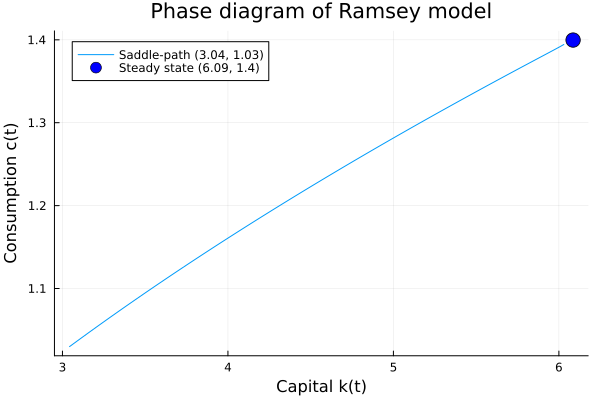

In [6]:
max_iter = 100 # Max iterations to avoid infinite loop
count = 0

# Return values of running the Ramsey model
check = false # will turn true if within ϵ_0 bound of steady state
# arrays to store trajectory in phase space
k_traj = []
c_traj = [] 

# Simulation loop
while check == false && count < max_iter 
    check, k_traj, c_traj = model(k_0, c_int, N)
    count += 1
end

# Control/result
print("Number of iterations: ", count)
print("\nc_0 = ", c_traj[1])

# Plot the resulting saddle-path to the steady state 
plot(k_traj, c_traj, label = "Saddle-path ($(round(k_traj[1],digits = 2)), $(round(c_traj[1],digits = 2)))")

# Highlight the steady state
scatter!([k_s], [c_s], label="Steady state ($(round(k_s, digits = 2)), $(round(c_s, digits = 2)))", markersize=8, markercolor= :blue)

# Formatting of plot
xlabel!("Capital k(t)")
ylabel!("Consumption c(t)")
title!("Phase diagram of Ramsey model")

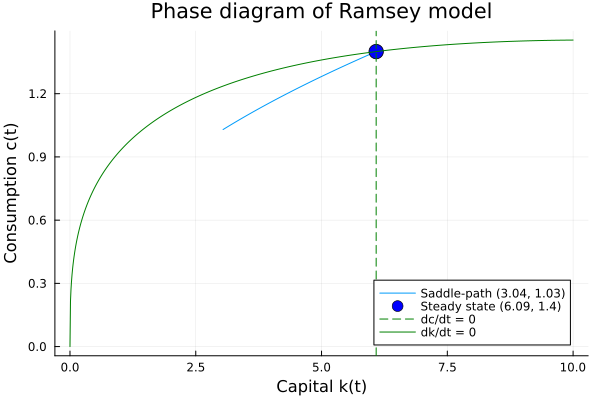

In [7]:
# plot stationary eqs
# dc/dt = 0
vline!([k_s], label="dc/dt = 0", color=:green, ls = :dash)
# dk/dt = 0
a = [0:0.01:10]
b = f.(a)-(δ+n) .* a
plot!(a,b, label = "dk/dt = 0", color=:green)

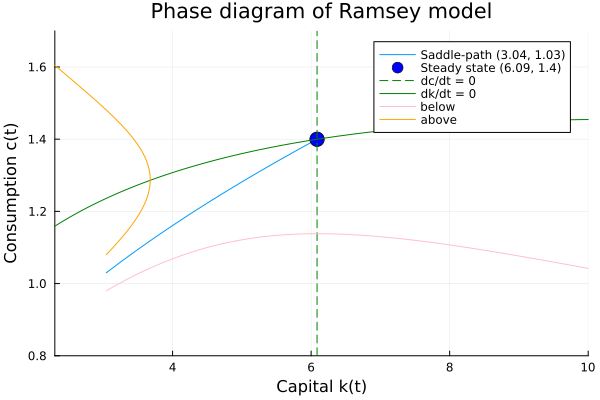

In [8]:
# Plot two additional trajectories
k_1, c_1 = trajectory(k_0, c_traj[1] - 0.05, k_max = 10)
k_2, c_2 = trajectory(k_0, c_traj[1] + 0.05, c_max = 1.6)

plot!(k_1, c_1, label = "below", color = :pink)
plot!(k_2, c_2, label = "above", color = :orange)

xlims!(2.3,10)
ylims!(0.8,1.7)